Qui troverai l'ultimo passo "dell'avventura" iniziata con [questo articolo](https://massimilianomoraca.me/blog/gis/pm10-nord-italia/) in cui riporto l'andamento del PM10 nel nord Italia nell'ultimo decennio. Il come ho proceduto all'analisi è riportato in [quest'altro articolo](https://massimilianomoraca.me/blog/pygis-blog/analisi-dellandamento-del-pm10-nel-nord-italia/).

Lo scopo dell'articolo che stai per leggere è visualizzare su mappa le aree di analisi, cosa che fino ad ora non avevo mostrato.

Tutto l'iter è stato bello lungo ed è per questo che l'ho dovuto suddividere in ben tre differenti articoli.

# Prima di iniziare

## Librerie

Come per tutti gli [articoli di PyGIS-Blog](https://massimilianomoraca.me/blog/pygis-blog/) inizio con l'elenco delle librerie usate. Una menzione speciale è per la funzione `xarray.open_mfdataset` perchè mi ha consentito di velocizzare tantissimo la lettura di tutti i file `.nc` grazie al nativo supporto a `dask.delayed`. 

Devo approfondire Dask appena ho tempo e [Dask Delayed](https://docs.dask.org/en/stable/delayed.html) sembra un buon punto di partenza pratico su cui lavorare per il mio solito training on the job :)

In [2]:
from pathlib import Path
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import patheffects

## Fonti dati

Come già spiegato nei precedenti articoli di questa involontaria miniserie, i dati usati sono quelli distributi dal Copernicus Atmosphere Monitoring Service. In particolare ho usato dati con una copertura temporale che va dal 2013 a marzo 2024.

In [10]:
main_folder = Path.cwd().parent.parent.parent.parent

main_city_path = main_folder.joinpath('sample_data', 'capoluoghi_di_regione.shp')
main_city = gpd.read_file(main_city_path)
main_city = main_city.to_crs(4326).sort_values('DEN_UTS')

target_zones_boundaries = main_folder.joinpath('sample_data').joinpath('ProvCM01012023_g').joinpath('ProvCM01012023_g_WGS84.shp')

target_zones = gpd.read_file(target_zones_boundaries)
target_zones = target_zones.to_crs(4326).sort_values('DEN_UTS')

pollutant = "particulate_matter_10um"
pollutant_code = pollutant #"SO2"
pollutant_day_limit = 50
max_overrunning = 35

figsize_w = 10
figsize_h = figsize_w / 1
plot_dpi = 300

polygon_facecolor = "none"
polygon_edgecolor = "#76CFEF"
polygon_linewidth = 1.0

marker_edgecolor = "black"
marker_facecolor = "red"
marker_type = "*"
marker_s = 250
marker_label_facecolor = "white"
marker_label_alpha = 0.75
marker_font_color = "black"
marker_font_size = 8
marker_x_offset = 0.05
marker_y_offset = -0.05

path_effects_linewidth = 3
path_effects_foreground = "white"

raster_cmap = "autumn"

In [11]:
nc_data_path = Path(f"/home/max/Desktop/so2_italia/processed/{pollutant}")

nc_files = list(nc_data_path.glob("*.nc"))

nc_files

[PosixPath('/home/max/Desktop/so2_italia/processed/particulate_matter_10um/particulate_matter_10um-2021-reanalyses.nc'),
 PosixPath('/home/max/Desktop/so2_italia/processed/particulate_matter_10um/particulate_matter_10um-2017-reanalyses.nc'),
 PosixPath('/home/max/Desktop/so2_italia/processed/particulate_matter_10um/particulate_matter_10um-2020-reanalyses.nc'),
 PosixPath('/home/max/Desktop/so2_italia/processed/particulate_matter_10um/particulate_matter_10um-2016-reanalyses.nc'),
 PosixPath('/home/max/Desktop/so2_italia/processed/particulate_matter_10um/particulate_matter_10um-2023-forecasts.nc'),
 PosixPath('/home/max/Desktop/so2_italia/processed/particulate_matter_10um/particulate_matter_10um-2019-reanalyses.nc'),
 PosixPath('/home/max/Desktop/so2_italia/processed/particulate_matter_10um/particulate_matter_10um-2018-reanalyses.nc'),
 PosixPath('/home/max/Desktop/so2_italia/processed/particulate_matter_10um/particulate_matter_10um-2022-forecasts.nc'),
 PosixPath('/home/max/Desktop/so2_

L'area geografica è sempre quella dei precedenti due articoli, la riporto comunque di seguito per completezza.

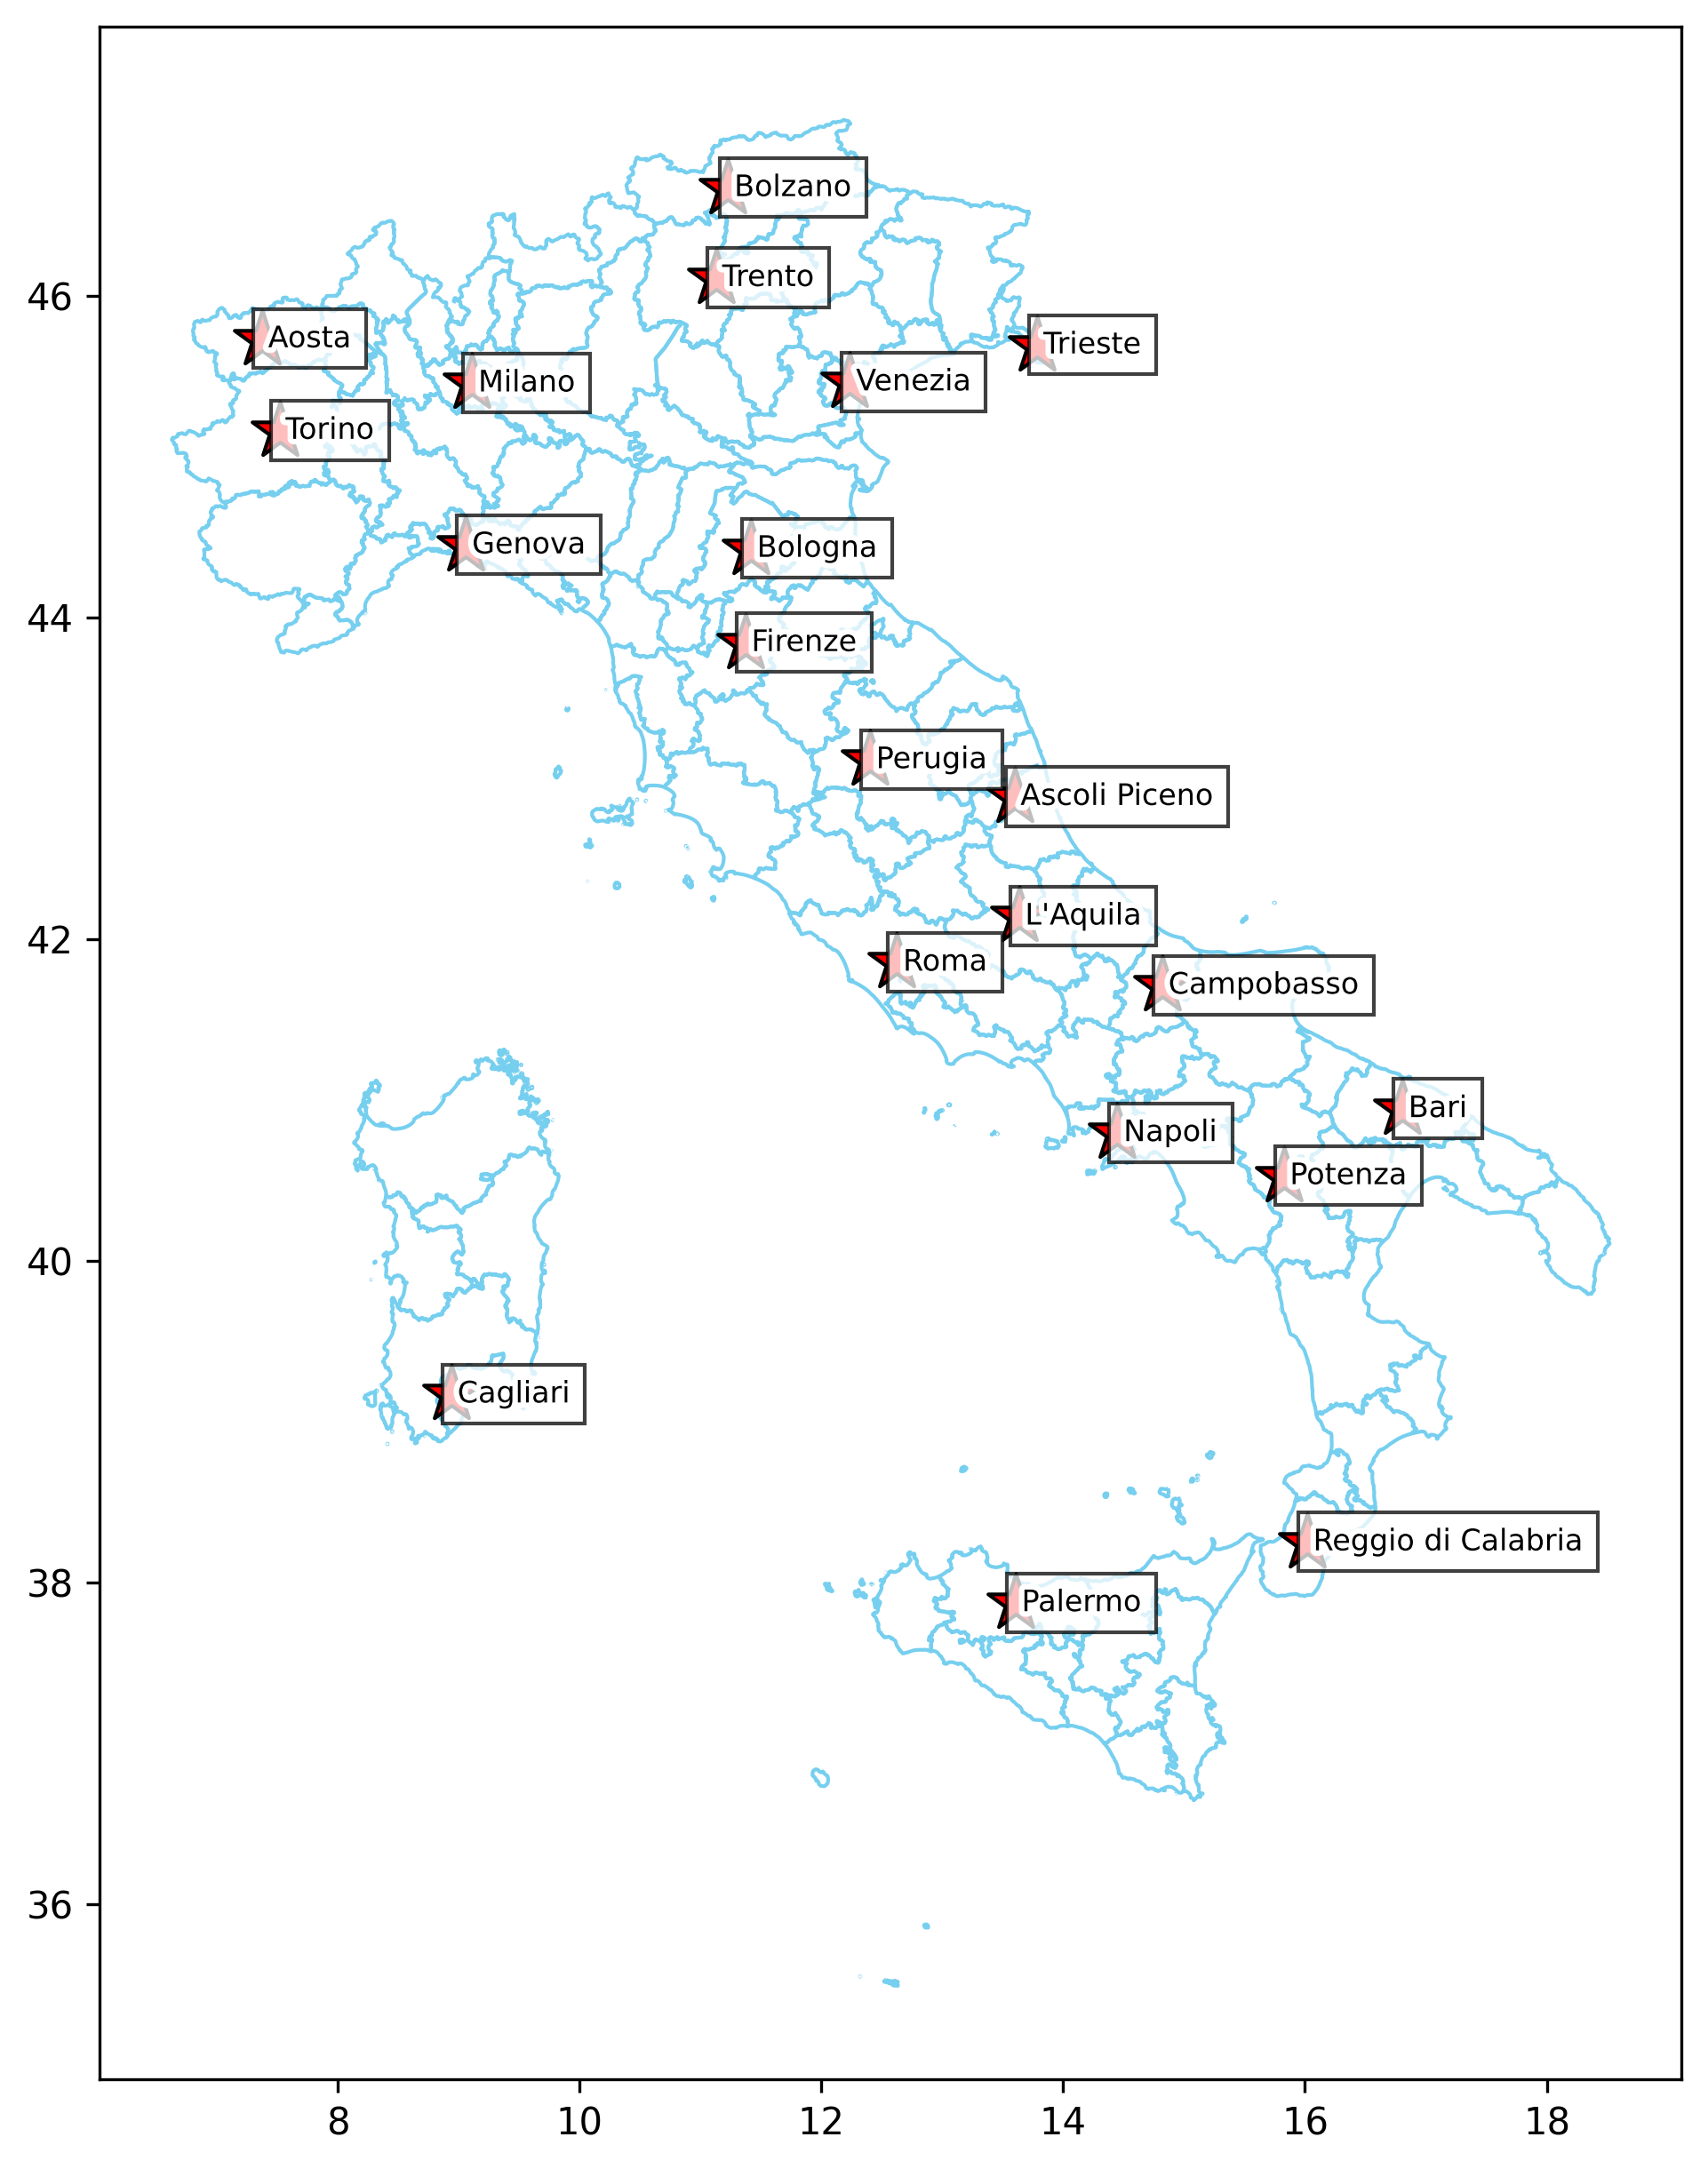

In [12]:
fig1, ax1 = plt.subplots(figsize=(figsize_w, figsize_h), dpi=plot_dpi)

target_zones.plot(
    ax=ax1,
    facecolor=polygon_facecolor, 
    edgecolor=polygon_edgecolor,
    linewidth=polygon_linewidth
)
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    ax1.scatter(
        *coordinates,
        s=marker_s,
        marker=marker_type,
        facecolor=marker_facecolor,
        edgecolor=marker_edgecolor
    )
    label = plt.text(
        x=coordinates[0][0] + marker_x_offset,
        y=coordinates[1][0] + marker_y_offset,
        s=_row['DEN_UTS'],
        fontdict=dict(color=marker_font_color, size=marker_font_size),
        bbox=dict(facecolor=marker_label_facecolor, alpha=marker_label_alpha),
        path_effects=[patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)]
    )
    label.set_path_effects([patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)])
plt.show()

## Contenuti
- [Analisi sul singolo file](#Analisi-sul-singolo-file)
- [Analisi su tutti i file](#Analisi-su-tutti-i-file)
- [Conclusione](#Conclusione)

# Analisi sul singolo file

## Lettura del `.nc`

Prima di iterare tutto il processo sull'intero arco temporale ho preferito effettuare delle verifiche su un solo anno, anche per prendere meglio confidenza con i dati.

In [15]:
single_dataset = xr.open_dataset(
    filename_or_obj=nc_files[1],
    engine="netcdf4",
    decode_coords="all",
)

single_dataset

<xarray.Dataset> Size: 643MB
Dimensions:                  (time: 8760, lon: 140, lat: 131)
Coordinates:
  * time                     (time) datetime64[ns] 70kB 2017-01-01 ... 2017-1...
  * lon                      (lon) float64 1kB 5.0 5.1 5.2 ... 18.7 18.8 18.9
  * lat                      (lat) float64 1kB 34.0 34.1 34.2 ... 46.8 46.9 47.0
    spatial_ref              int64 8B ...
    level                    int64 8B ...
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 643MB ...
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

Come si può vedere, il Dataset del 2013 è composto da 8760 ore (24h x 365d) per un peso di ben 163MB. Ricordo che la risoluzione spaziale di questi dati è circa 7.5km x 7.5km.

### Analisi sul singolo giorno

Di seguito punto all'estrazione e visualizzazione di una singola ora di un singolo giorno.

In [16]:
target_test_time = '2017-02-09T13:00:00'

target_hour_selection = single_dataset.sel(time=target_test_time).to_array().squeeze()

target_hour_selection

<xarray.DataArray (lat: 131, lon: 140)> Size: 73kB
array([[ 9.44945  , 19.364971 , 26.31276  , ..., 10.671627 , 10.214291 ,
         9.766022 ],
       [ 6.3833866, 10.9111   , 10.283637 , ..., 10.3001795,  9.87148  ,
         9.490645 ],
       [ 6.514001 ,  6.538168 ,  6.607768 , ..., 10.144887 ,  9.751037 ,
         9.386204 ],
       ...,
       [33.079163 , 31.38752  , 29.990562 , ..., 23.195639 , 23.544897 ,
        23.875736 ],
       [32.05453  , 31.412144 , 30.712578 , ..., 22.689108 , 22.507153 ,
        23.052114 ],
       [30.436623 , 30.940428 , 30.667427 , ..., 22.491251 , 22.207148 ,
        22.432886 ]], dtype=float32)
Coordinates:
    time         datetime64[ns] 8B 2017-02-09T13:00:00
  * lon          (lon) float64 1kB 5.0 5.1 5.2 5.3 5.4 ... 18.6 18.7 18.8 18.9
  * lat          (lat) float64 1kB 34.0 34.1 34.2 34.3 ... 46.7 46.8 46.9 47.0
    spatial_ref  int64 8B ...
    level        int64 8B ...
    variable     <U23 92B 'particulate_matter_10um'
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

In [17]:
s_min = target_hour_selection.min().values.round(2)
s_max = target_hour_selection.max().values.round(2)

print(f"Nell'ora presa in considerazione si nota che\n il {pollutant_code} minimo era pari a {s_min} µg/m3\n ed il massimo era {s_max} µg/m3")

Nell'ora presa in considerazione si nota che
 il particulate_matter_10um minimo era pari a 0.5299999713897705 µg/m3
 ed il massimo era 143.66000366210938 µg/m3


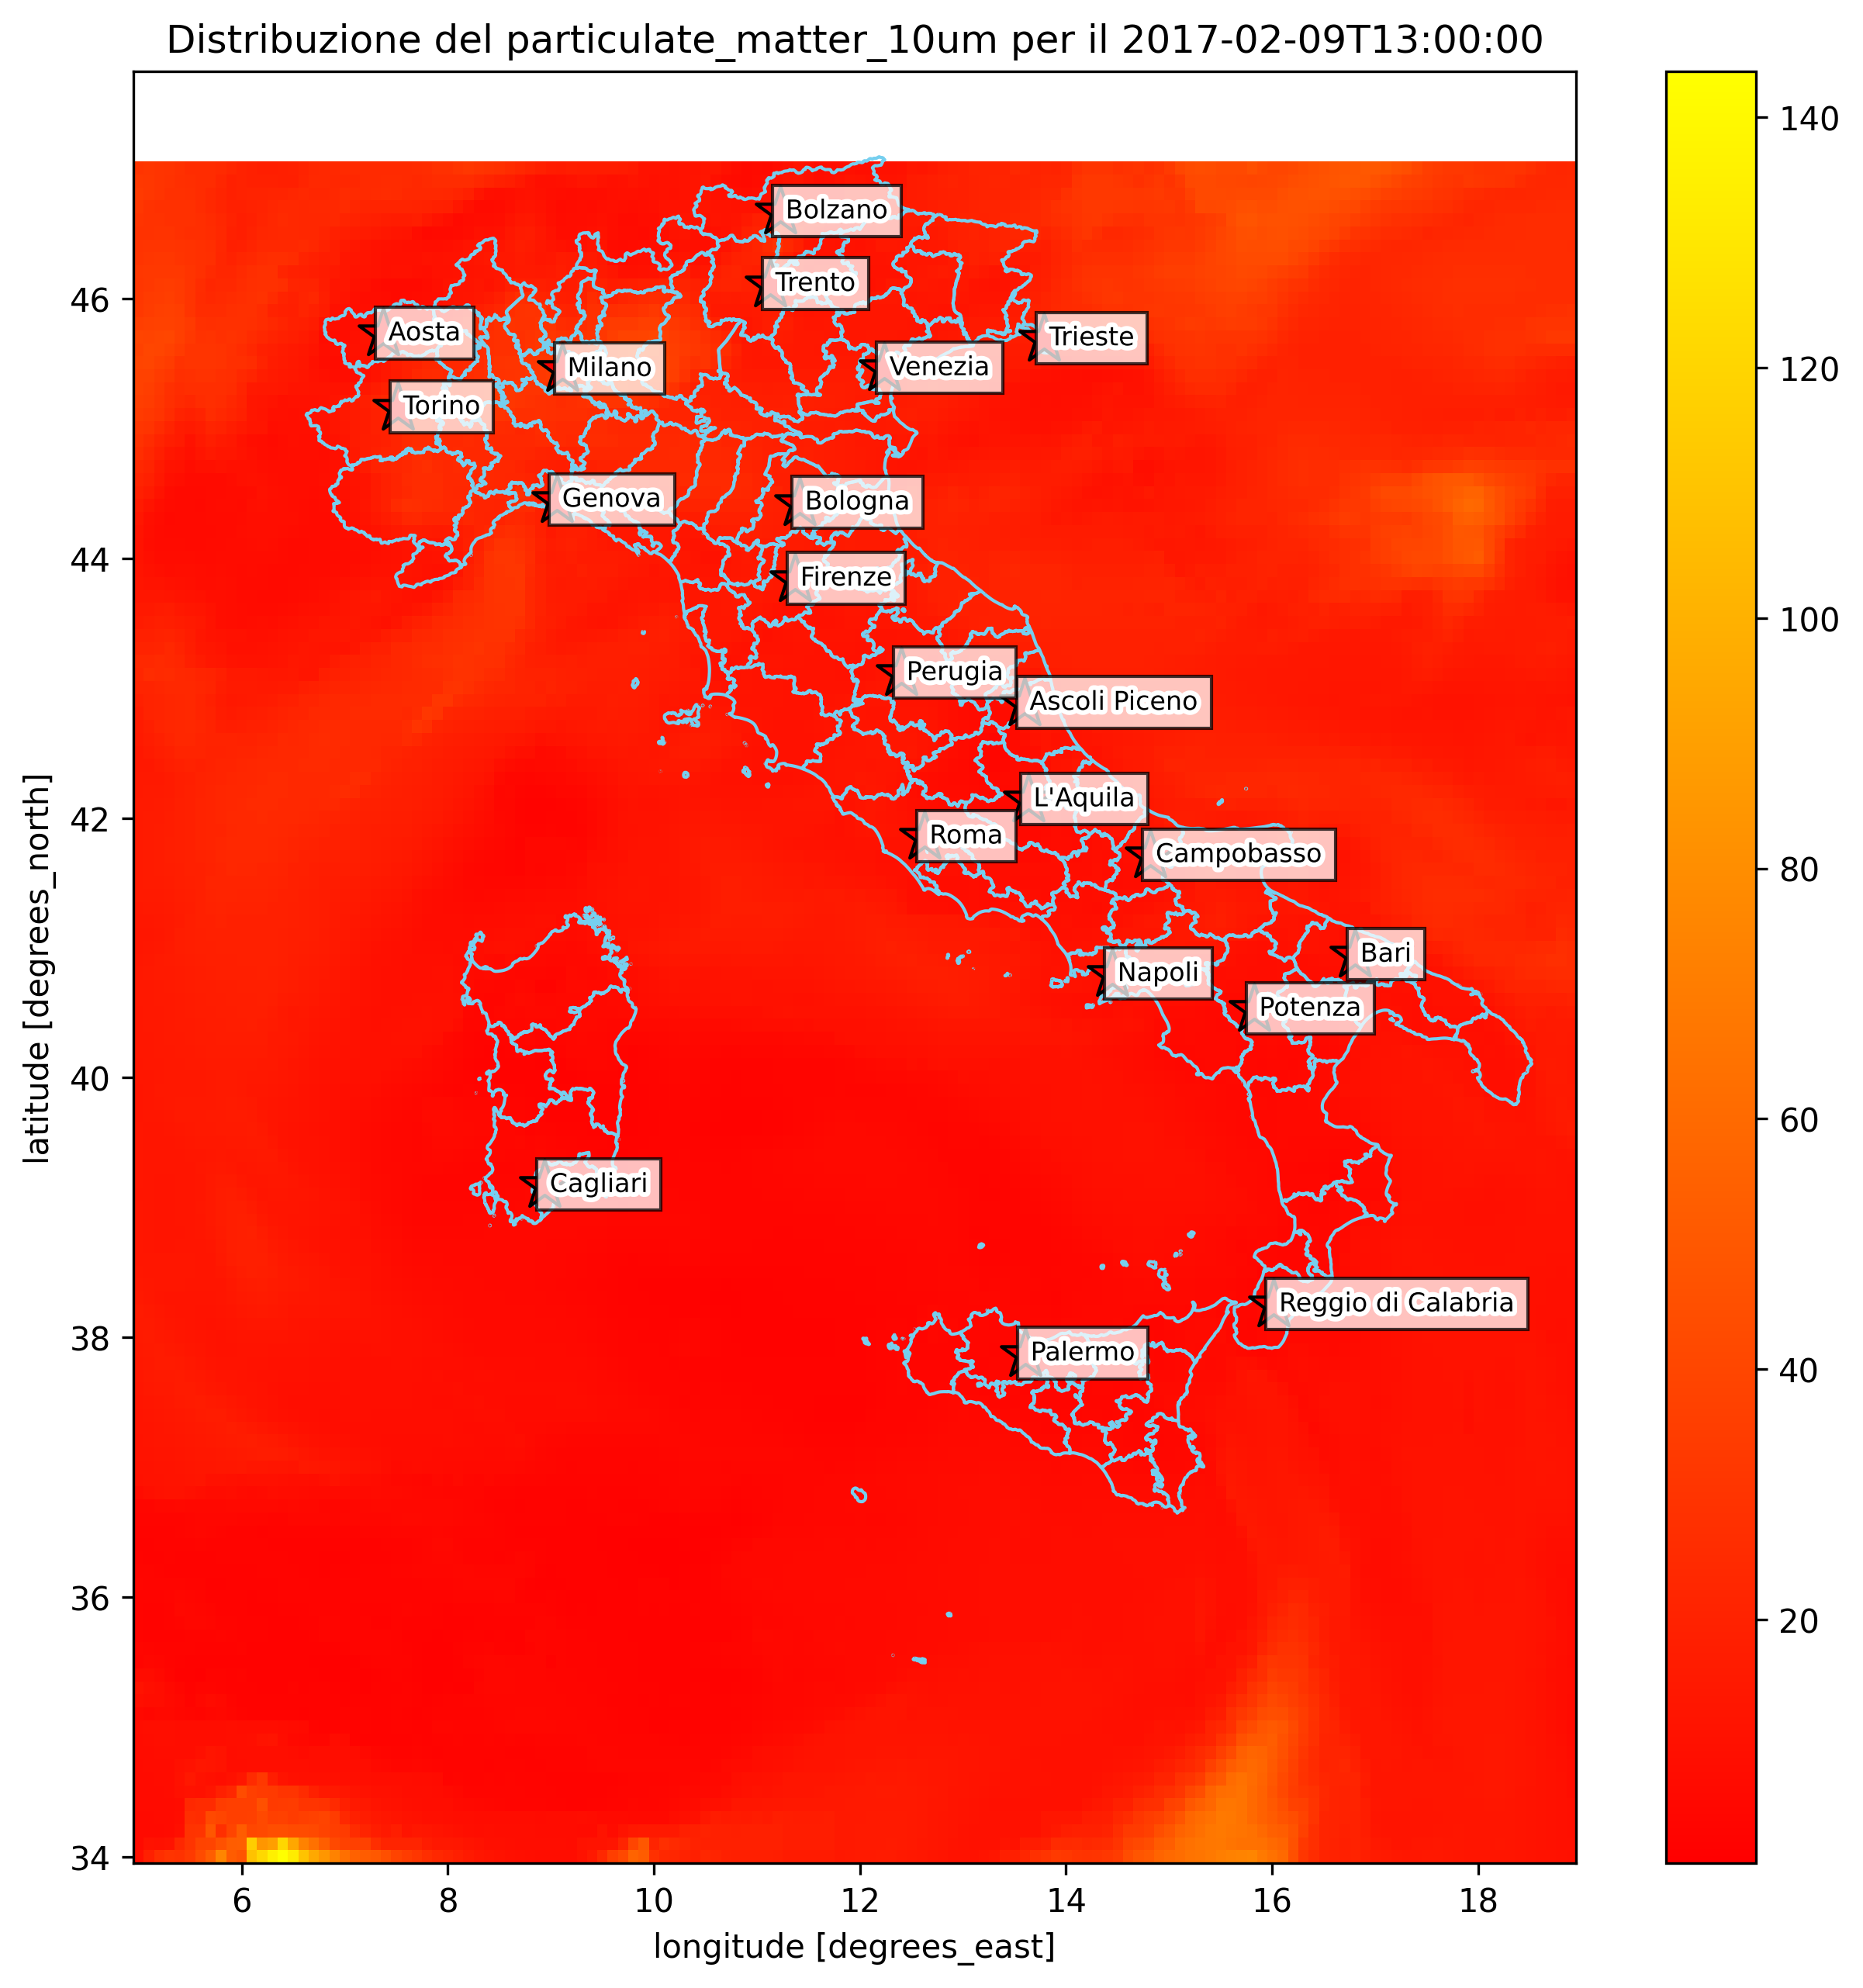

In [18]:
fig2, ax2 = plt.subplots(figsize=(figsize_w, figsize_h), dpi=plot_dpi)

target_zones.plot(
    ax=ax2,
    facecolor=polygon_facecolor, 
    edgecolor=polygon_edgecolor,
    linewidth=polygon_linewidth
)
target_hour_selection.plot.imshow(
    ax=ax2,
    cmap=raster_cmap,
)
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    ax2.scatter(
        *coordinates,
        s=marker_s,
        marker=marker_type,
        facecolor=marker_facecolor,
        edgecolor=marker_edgecolor
    )
    label = plt.text(
        x=coordinates[0][0] + marker_x_offset,
        y=coordinates[1][0] + marker_y_offset,
        s=_row['DEN_UTS'],
        fontdict=dict(color=marker_font_color, size=marker_font_size),
        bbox=dict(facecolor=marker_label_facecolor, alpha=marker_label_alpha),
        path_effects=[patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)]
    )
    label.set_path_effects([patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)])
plt.title(f"Distribuzione del {pollutant_code} per il {target_test_time}")
plt.show()

## Conteggio degli sforamenti in un anno

Di seguito calcolo la media giornaliera per tutto l'anno in esame.

In [19]:
daily_data = single_dataset.resample(time='D').mean('time')  

daily_data

<xarray.Dataset> Size: 27MB
Dimensions:                  (lon: 140, lat: 131, time: 365)
Coordinates:
  * lon                      (lon) float64 1kB 5.0 5.1 5.2 ... 18.7 18.8 18.9
  * lat                      (lat) float64 1kB 34.0 34.1 34.2 ... 46.8 46.9 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 3kB 2017-01-01 ... 2017-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 27MB 6.019 6.052 ... 13.56
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

Quindi seleziono le sole celle che sforano il limite di 50 µg/m3 previsti dalla normativa.

In [20]:
daily_data_target = daily_data.copy()
daily_data_target[pollutant] = xr.where(daily_data[pollutant] >= pollutant_day_limit, 1, 0)

daily_data_target

<xarray.Dataset> Size: 54MB
Dimensions:                  (lon: 140, lat: 131, time: 365)
Coordinates:
  * lon                      (lon) float64 1kB 5.0 5.1 5.2 ... 18.7 18.8 18.9
  * lat                      (lat) float64 1kB 34.0 34.1 34.2 ... 46.8 46.9 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 3kB 2017-01-01 ... 2017-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 54MB 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

I pixel che sforano il limite li ho sostituiti con il valore 1 e gli altri con 0, in questo modo con il passaggio successivo ho potuto calcolare quante volte viene sforato il limite.

In [21]:
year_data = daily_data_target.resample(time='YE').sum('time')  

year_data

<xarray.Dataset> Size: 149kB
Dimensions:                  (lon: 140, lat: 131, time: 1)
Coordinates:
  * lon                      (lon) float64 1kB 5.0 5.1 5.2 ... 18.7 18.8 18.9
  * lat                      (lat) float64 1kB 34.0 34.1 34.2 ... 46.8 46.9 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 8B 2017-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 147kB 61 60 60 60 ... 4 5 5
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

In [22]:
y_min = year_data.min().to_array().values[0]
y_max = year_data.max().to_array().values[0]

print(f"Nell'anno preso in considerazione i valori di {pollutant_code}\n limite previsti dalla normativa sono stati sforati\n per un massimo di {y_max} volte. Il limite normativo è {max_overrunning}.")

Nell'anno preso in considerazione i valori di particulate_matter_10um
 limite previsti dalla normativa sono stati sforati
 per un massimo di 80 volte. Il limite normativo è 35.


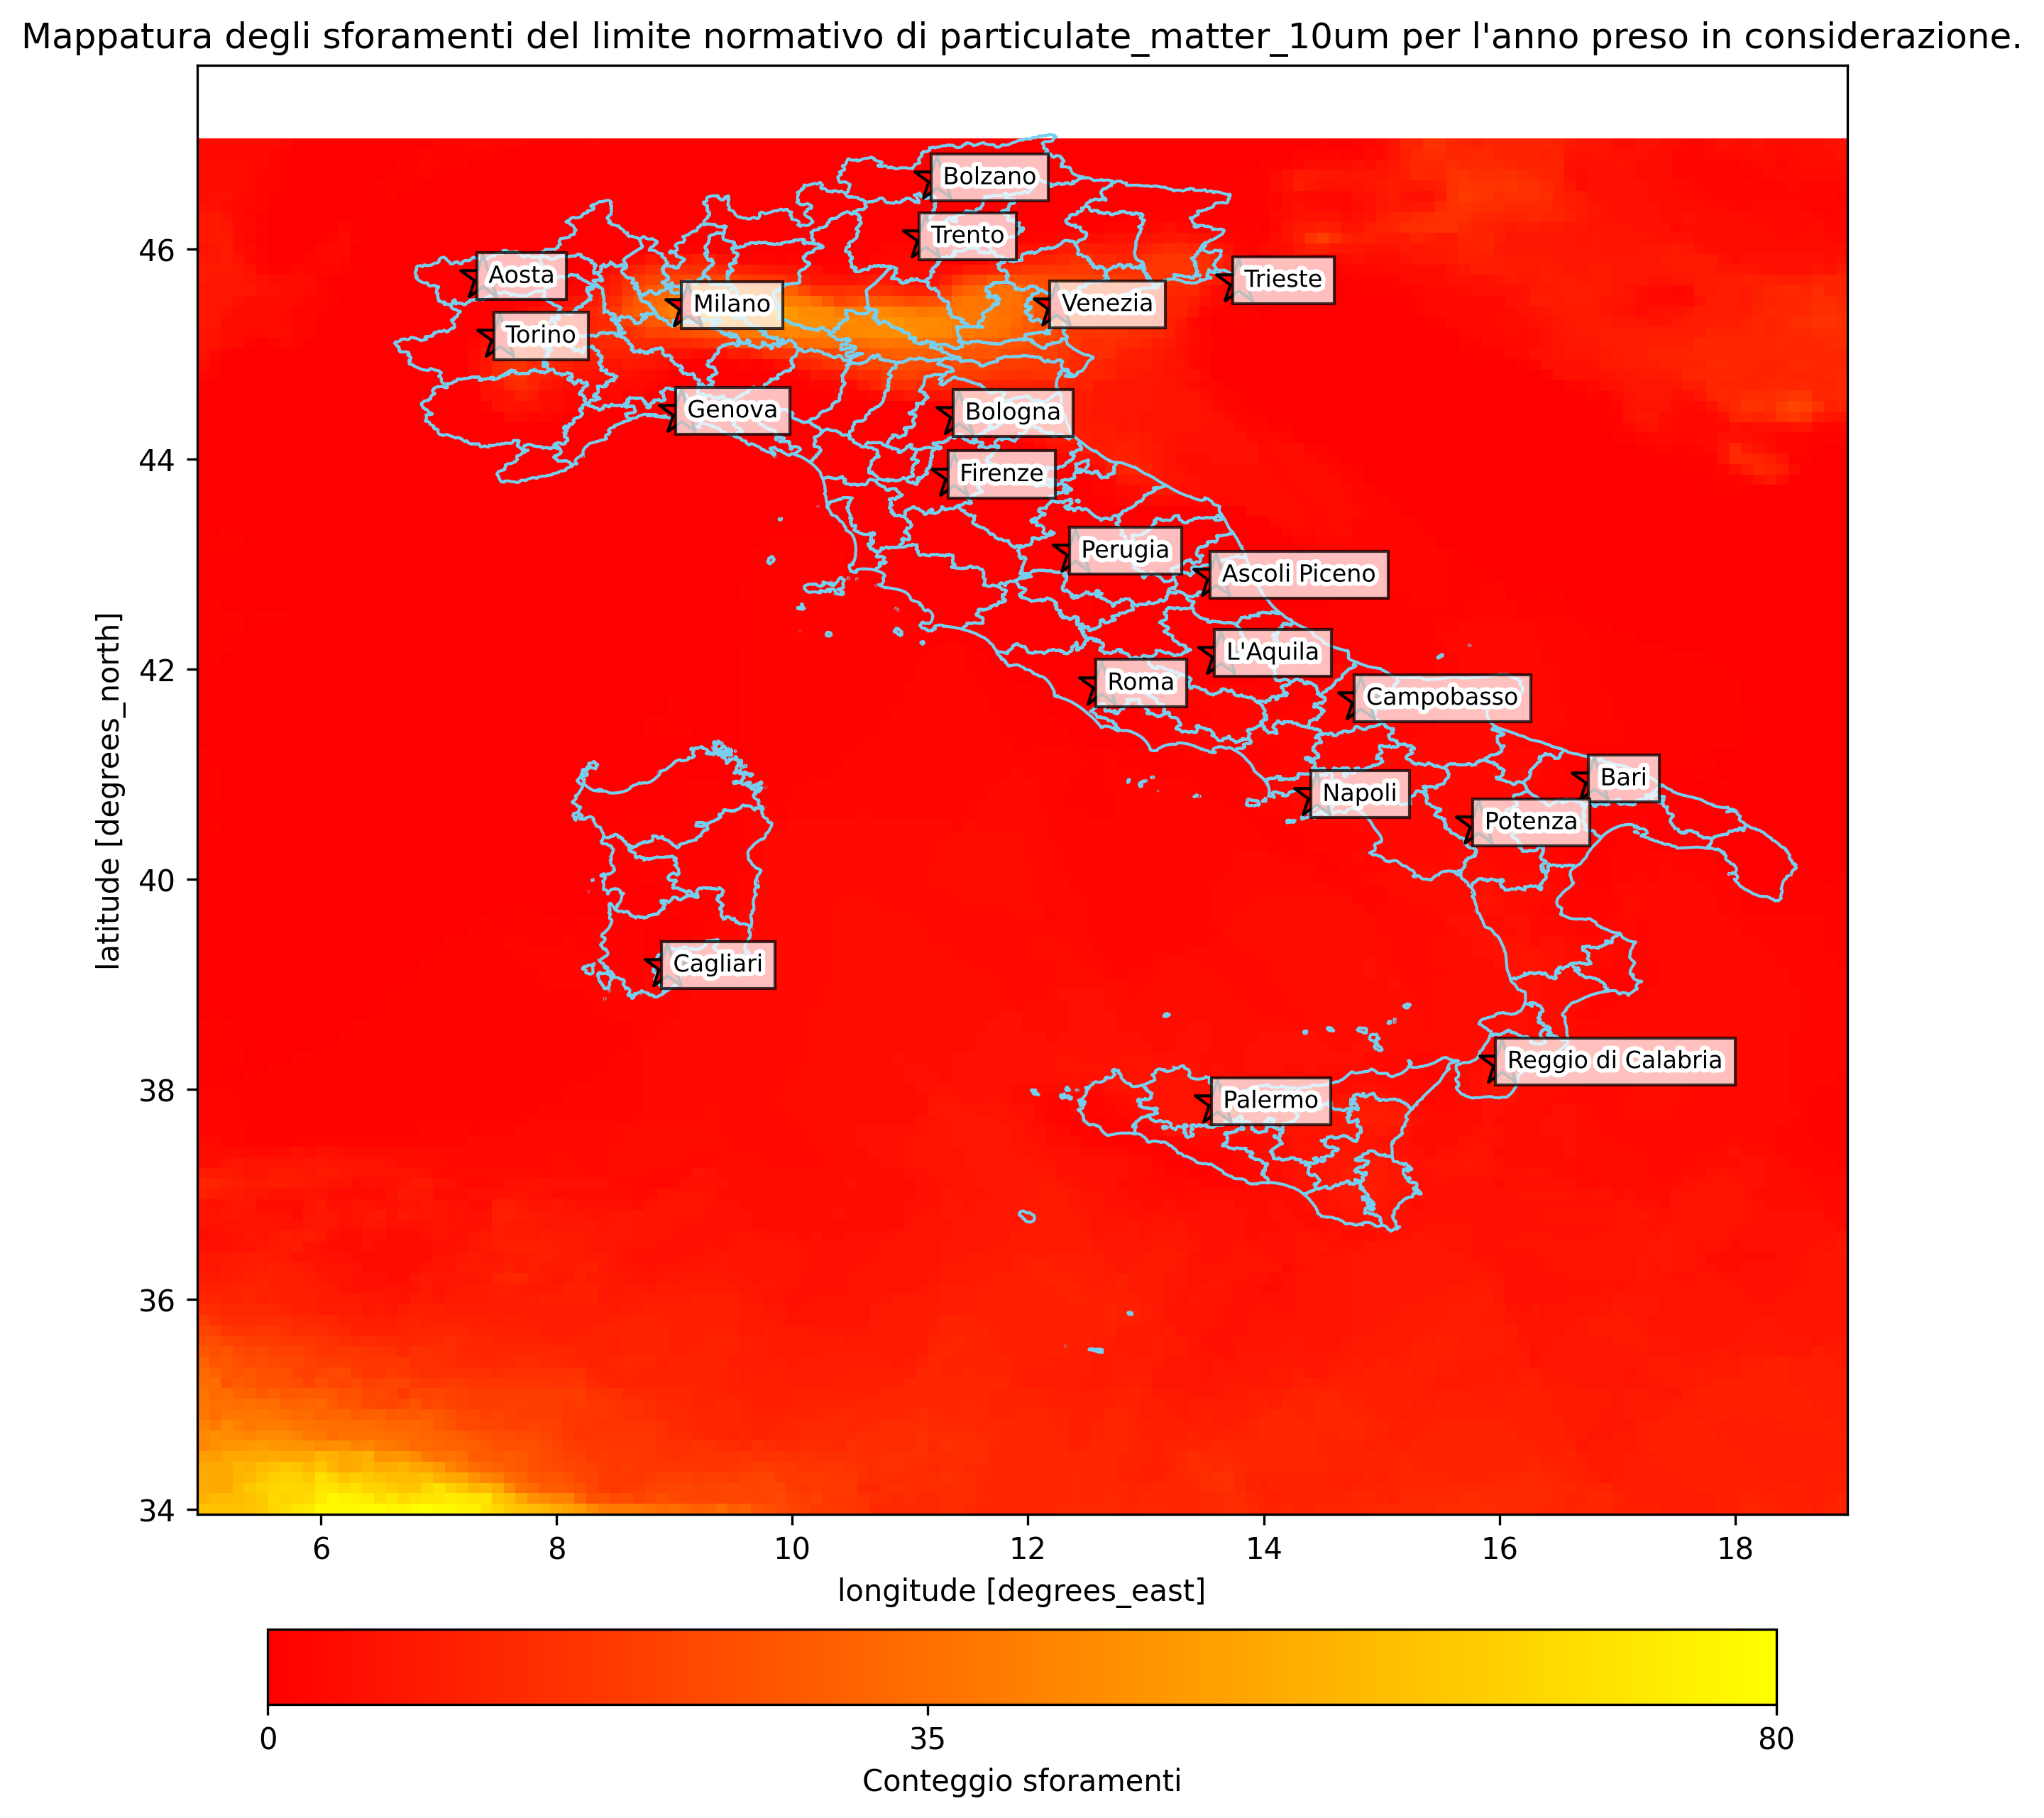

In [23]:
fig3, ax3 = plt.subplots(figsize=(figsize_w, figsize_h), dpi=plot_dpi)

add_colorbar = False
colorbar_orientation = "horizontal"
colorbar_fraction = 0.046
colorbar_pad = 0.07

target_zones.plot(
    ax=ax3,
    facecolor=polygon_facecolor, 
    edgecolor=polygon_edgecolor,
    linewidth=polygon_linewidth
)
year_data_img = year_data.to_array().squeeze().plot.imshow(
    ax=ax3,
    cmap=raster_cmap,
    vmin=y_min,
    vmax=y_max,
    add_colorbar=add_colorbar,
)
cbar_ax3 = plt.colorbar(
    year_data_img, 
    ax=ax3,
    orientation=colorbar_orientation,
    fraction=colorbar_fraction, 
    pad=colorbar_pad,
)
cbar_ax3.set_label('Conteggio sforamenti')
cbar_ax3.set_ticks([y_min, max_overrunning, y_max])
cbar_ax3.set_ticklabels([str(y_min), str(max_overrunning), str(y_max)])
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    ax3.scatter(
        *coordinates,
        s=marker_s,
        marker=marker_type,
        facecolor=marker_facecolor,
        edgecolor=marker_edgecolor
    )
    label = plt.text(
        x=coordinates[0][0] + marker_x_offset,
        y=coordinates[1][0] + marker_y_offset,
        s=_row['DEN_UTS'],
        fontdict=dict(color=marker_font_color, size=marker_font_size),
        bbox=dict(facecolor=marker_label_facecolor, alpha=marker_label_alpha),
        path_effects=[patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)]
    )
    label.set_path_effects([patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)])
plt.title(f"Mappatura degli sforamenti del limite normativo di {pollutant_code} per l'anno preso in considerazione.")
plt.show()

Ora voglio visualizzare solo le aree che hanno effettivamente sforato il limite normativo di 35 sforamenti annui.

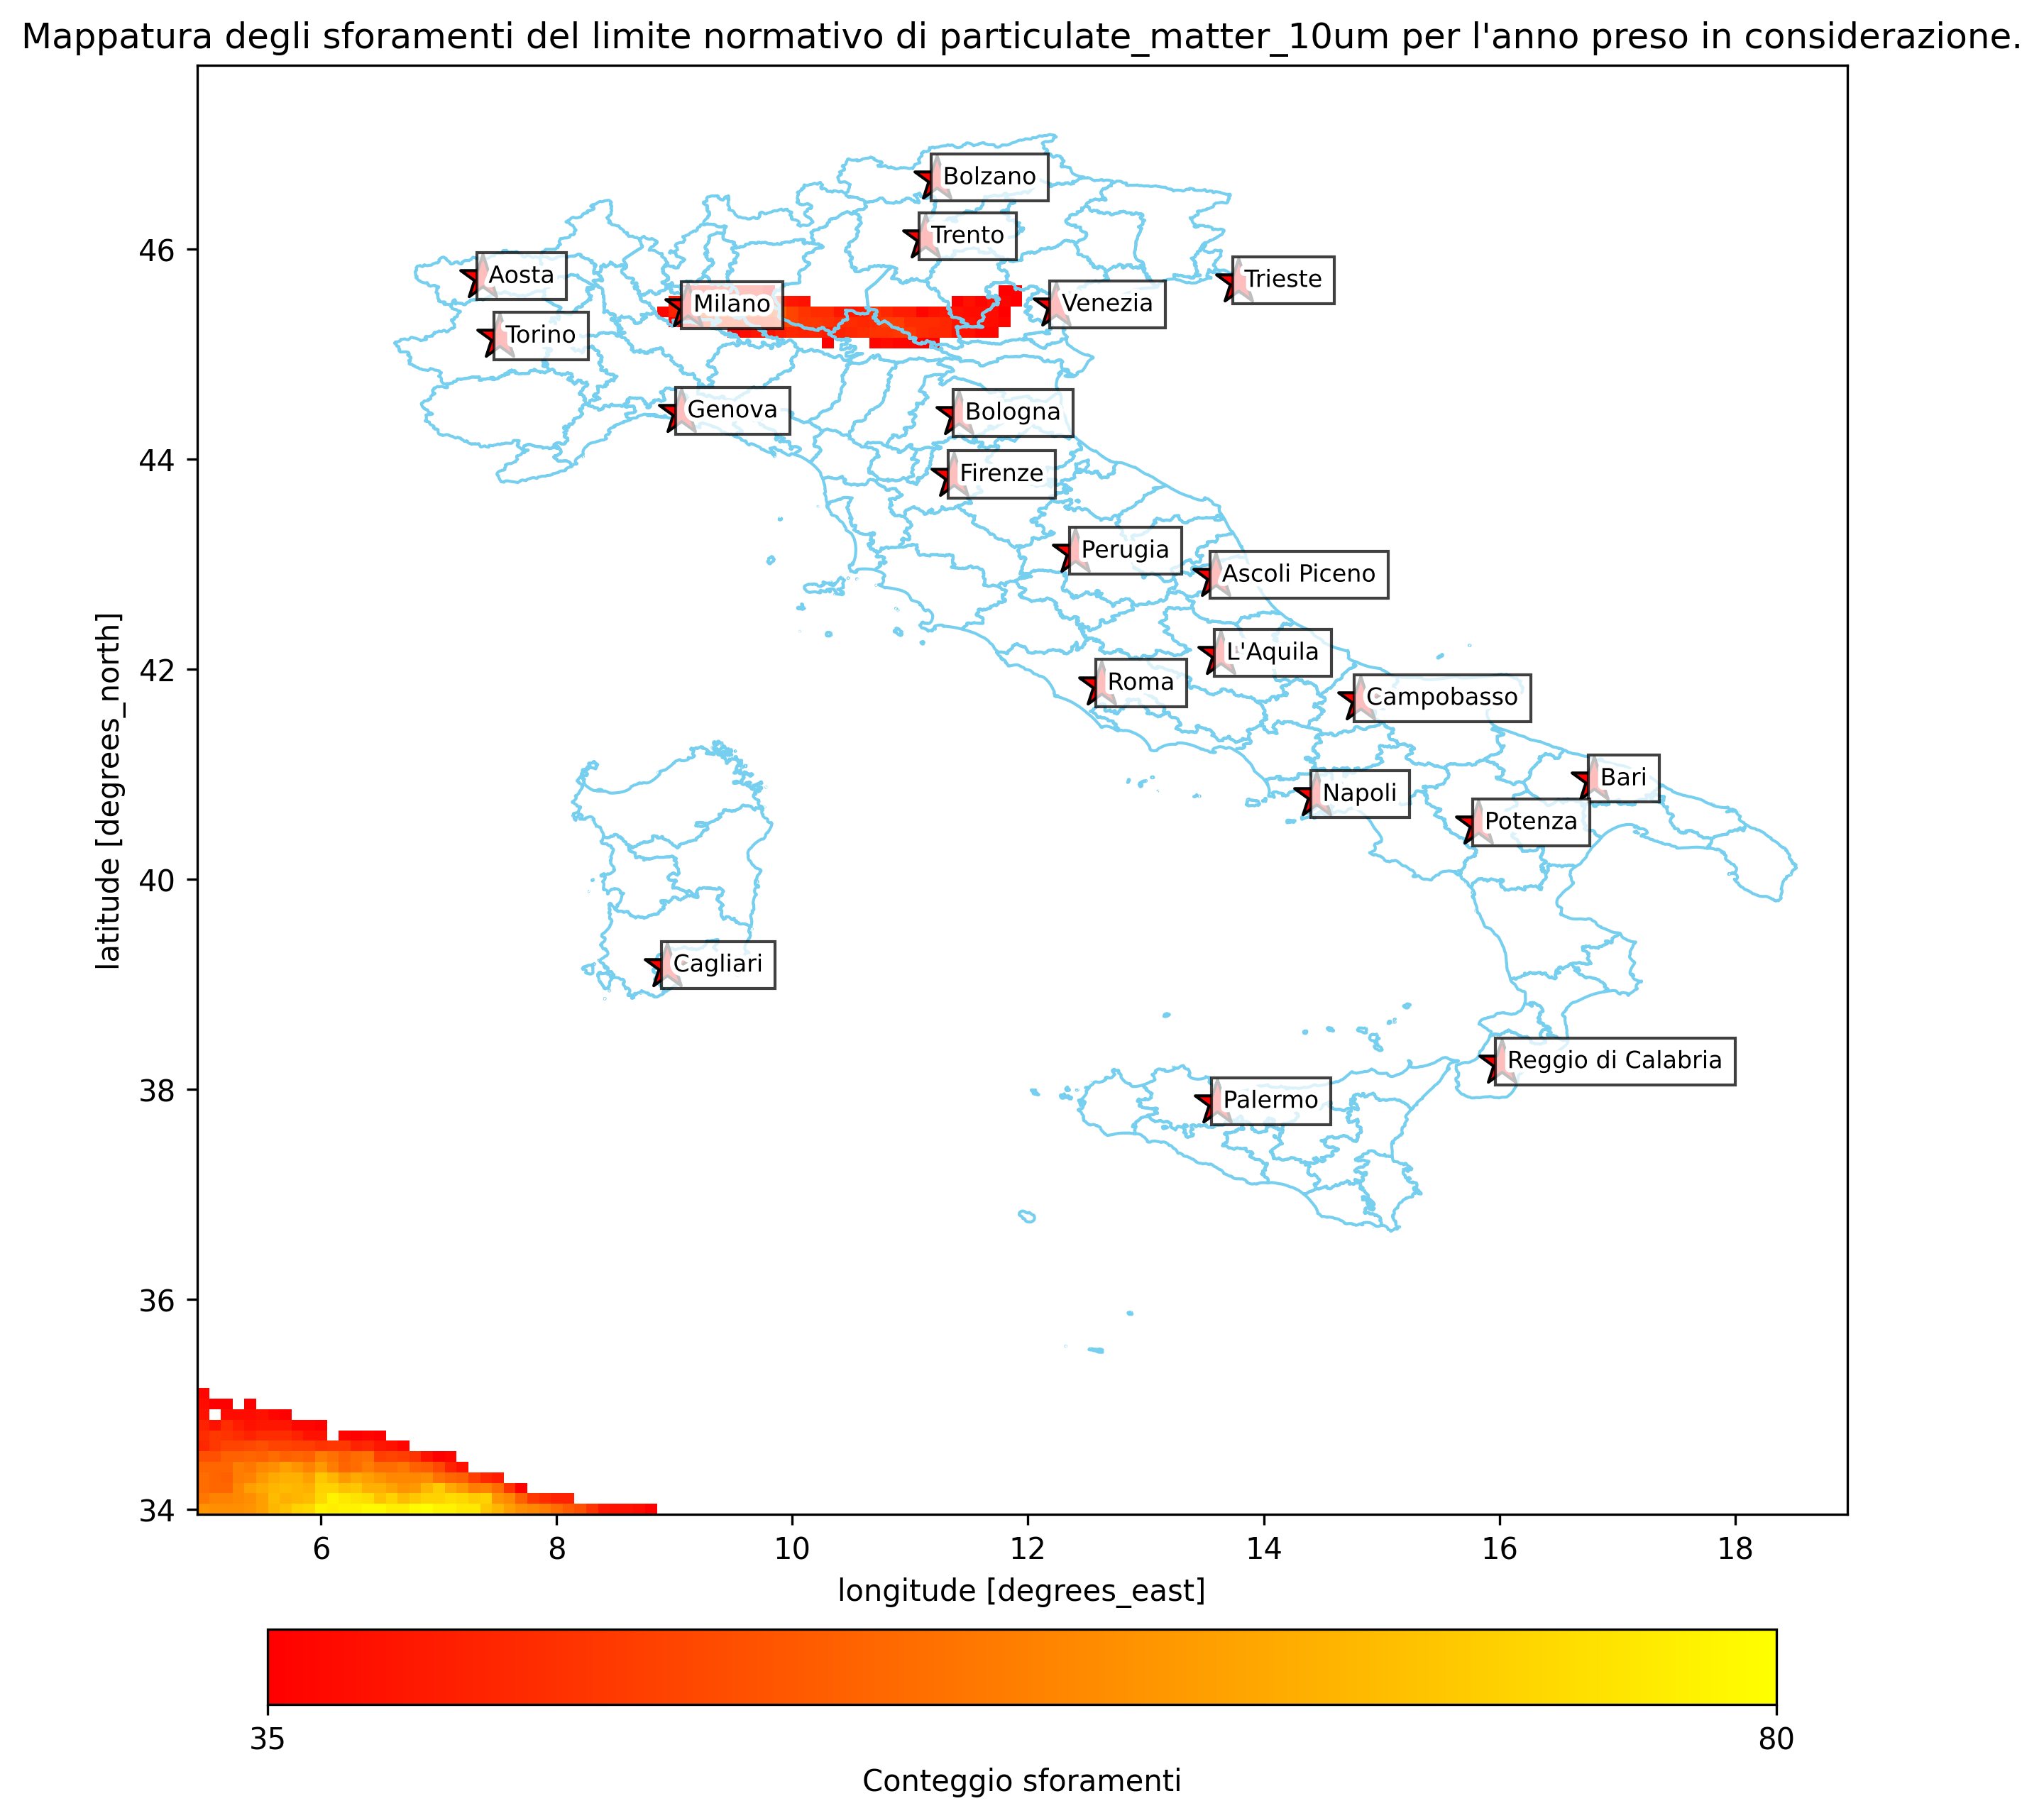

In [24]:
year_data_limit = year_data.where(year_data >= max_overrunning)

fig4, ax4 = plt.subplots(figsize=(figsize_w, figsize_h), dpi=plot_dpi)
target_zones.plot(
    ax=ax4,
    facecolor=polygon_facecolor, 
    edgecolor=polygon_edgecolor,
    linewidth=polygon_linewidth
)
year_data_img_limit = year_data_limit.to_array().squeeze().plot.imshow(
    ax=ax4,
    cmap=raster_cmap,
    vmin=max_overrunning,
    vmax=y_max,
    add_colorbar=add_colorbar,
)
cbar_ax4 = plt.colorbar(
    year_data_img_limit, 
    ax=ax4,
    orientation=colorbar_orientation,
    fraction=colorbar_fraction, 
    pad=colorbar_pad,
)
cbar_ax4.set_label('Conteggio sforamenti')
cbar_ax4.set_ticks([max_overrunning, y_max])
cbar_ax4.set_ticklabels([str(max_overrunning), str(y_max)])
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    ax4.scatter(
        *coordinates,
        s=marker_s,
        marker=marker_type,
        facecolor=marker_facecolor,
        edgecolor=marker_edgecolor
    )
    label = plt.text(
        x=coordinates[0][0] + marker_x_offset,
        y=coordinates[1][0] + marker_y_offset,
        s=_row['DEN_UTS'],
        fontdict=dict(color=marker_font_color, size=marker_font_size),
        bbox=dict(facecolor=marker_label_facecolor, alpha=marker_label_alpha),
        path_effects=[patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)]
    )
    label.set_path_effects([patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)])
plt.title(f"Mappatura degli sforamenti del limite normativo di {pollutant_code} per l'anno preso in considerazione.")
plt.show()

# Analisi su tutti i file

Ora che ho familiarizzato con il dato del singolo anno procedo ad analizzare tutto in una unica volta.

In [25]:
%%time

complete_dataset = []

for nc_file in nc_files:
    dataset = xr.open_mfdataset(
        paths=nc_file,
        engine="netcdf4",
        decode_coords="all",
        parallel=True,
        chunks={'time': 24},
    )
    complete_dataset.append(dataset)

full_dataset = xr.concat(complete_dataset, dim="time")
full_dataset = full_dataset.sortby('time')

full_dataset

CPU times: user 156 ms, sys: 27.7 ms, total: 183 ms
Wall time: 201 ms


<xarray.Dataset> Size: 45GB
Dimensions:                  (lon: 420, lat: 365, time: 73464)
Coordinates:
  * lon                      (lon) float64 3kB 5.0 5.05 5.05 ... 18.95 18.95
  * lat                      (lat) float64 3kB 34.0 34.05 34.05 ... 46.95 47.0
  * time                     (time) datetime64[ns] 588kB 2016-01-01 ... 2024-...
    spatial_ref              int64 8B 0
    level                    int64 8B 0
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 45GB dask.array<chunksize=(24, 365, 420), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality validated reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

Da notare che l'intero dataset pesa 20GB!

Procedo con il calcolo della media giornaliera e la sostituzione dei valori di sforamento con 1.

In [26]:
%%time

full_dataset_daily_data = full_dataset.resample(time='D').mean('time')  

full_dataset_daily_data

CPU times: user 6.08 s, sys: 73.2 ms, total: 6.16 s
Wall time: 6.1 s


<xarray.Dataset> Size: 2GB
Dimensions:                  (lon: 420, lat: 365, time: 3061)
Coordinates:
  * lon                      (lon) float64 3kB 5.0 5.05 5.05 ... 18.95 18.95
  * lat                      (lat) float64 3kB 34.0 34.05 34.05 ... 46.95 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 24kB 2016-01-01 ... 2024-0...
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 2GB dask.array<chunksize=(1, 365, 420), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality validated reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

In [27]:
%%time

full_dataset_daily_data_target = full_dataset_daily_data.copy()
full_dataset_daily_data_target[pollutant] = xr.where(full_dataset_daily_data_target[pollutant] > pollutant_day_limit, 1, 0)

full_dataset_daily_data_target

CPU times: user 8.53 ms, sys: 150 µs, total: 8.68 ms
Wall time: 8.64 ms


<xarray.Dataset> Size: 4GB
Dimensions:                  (lon: 420, lat: 365, time: 3061)
Coordinates:
  * lon                      (lon) float64 3kB 5.0 5.05 5.05 ... 18.95 18.95
  * lat                      (lat) float64 3kB 34.0 34.05 34.05 ... 46.95 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 24kB 2016-01-01 ... 2024-0...
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 4GB dask.array<chunksize=(1, 365, 420), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality validated reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

A questo punto posso conteggiare gli sforamenti per tutto il dataset

In [28]:
full_dataset_year_data = full_dataset_daily_data_target.resample(time='YE').sum('time')  
full_dataset_year_data = full_dataset_year_data.where(full_dataset_year_data >= max_overrunning)
full_dataset_year_data

<xarray.Dataset> Size: 11MB
Dimensions:                  (time: 9, lat: 365, lon: 420)
Coordinates:
  * lon                      (lon) float64 3kB 5.0 5.05 5.05 ... 18.95 18.95
  * lat                      (lat) float64 3kB 34.0 34.05 34.05 ... 46.95 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 72B 2016-12-31 ... 2024-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) float64 11MB dask.array<chunksize=(1, 365, 420), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality validated reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

Il dataset a questo punto si è ridotto tantissimo in peso.

In [29]:
overruning = full_dataset_year_data.max().to_array().values[0]

try:
    full_max = int(overruning)
except ValueError:
    full_max = 0
    
print(f"Nell'anno preso in considerazione i valori di {pollutant_code}\n limite previsti dalla normativa sono stati sforati per un\n massimo di {full_max} volte")

Nell'anno preso in considerazione i valori di particulate_matter_10um
 limite previsti dalla normativa sono stati sforati per un
 massimo di 148 volte


In [30]:
%%time

dataset_list = []
target_shape = (50, 90)
img_folder = Path.cwd().joinpath('img')

for nc_file in nc_files:
    dataset = xr.open_mfdataset(
        paths=nc_file,
        engine="netcdf4",
        decode_coords="all",
        parallel=True,
        chunks={'time': 24},
    )
    dataset = dataset.sortby('time')
    
    daily_mean = dataset.resample(time='D').mean('time')  

    anomaly = daily_mean.copy()
    anomaly[pollutant] = xr.where(daily_mean[pollutant] >= pollutant_day_limit, 1, 0)
    
    out_layer = anomaly.resample(time='YE').sum('time')  
    out_layer = out_layer.where(out_layer >= 35)
    year = str(out_layer['time'].values[0])[:4]

    fig5, ax5 = plt.subplots(figsize=(figsize_w, figsize_h), dpi=plot_dpi)
    target_zones.plot(
        ax=ax5,
        facecolor=polygon_facecolor, 
        edgecolor=polygon_edgecolor,
        linewidth=polygon_linewidth
    )
    year_data_img_limit = out_layer.to_array().squeeze().plot.imshow(
        ax=ax5,
        cmap=raster_cmap,
        vmin=max_overrunning,
        vmax=full_max,
        add_colorbar=add_colorbar,
    )
    cbar_ax5 = plt.colorbar(
        year_data_img_limit, 
        ax=ax5,
        orientation=colorbar_orientation,
        fraction=colorbar_fraction, 
        pad=colorbar_pad,
    )
    cbar_ax5.set_label('Conteggio sforamenti')
    cbar_ax5.set_ticks([max_overrunning,  full_max])
    cbar_ax5.set_ticks([max_overrunning, full_max])
    cbar_ax5.set_ticklabels([str(max_overrunning), str(full_max)])
    for _index, _row in main_city.iterrows():
        coordinates = _row.geometry.xy
        label = plt.text(
            x=coordinates[0][0] + marker_x_offset,
            y=coordinates[1][0] + marker_y_offset,
            s=_row['DEN_UTS'],
            fontdict=dict(color=marker_font_color, size=marker_font_size),
            path_effects=[patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)]
        )
        label.set_path_effects([patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)])
    plt.title(f"Mappatura degli sforamenti del limite normativo di {pollutant_code} per l'anno {year}")
    
    # Save chart
    chart_name = f'{pollutant}anno_{year}.jpg'
    plt.savefig(img_folder.joinpath(chart_name))
    plt.close(fig5) # Avoid to show the figure


CPU times: user 22 s, sys: 3.44 s, total: 25.4 s
Wall time: 17.6 s


![Inquinamento mappato](https://raw.githubusercontent.com/MaxDragonheart/PyGIS-Blog/52405c3ad9bb1166fbdfdfecbb36e758b6d30929/notebooks/2024/05/18/img/inquinamento_mappato.gif)

# Conclusione

A parte il poco tempo che ho avuto in questi mesi, l'analisi è stata davvero molto complessa, le difficoltà non sono mancate. Una cosa che non sono riuscito a risolvere è il problema che espongo di seguito e che mi ha costretto ad usare il ciclo for per creare le immagini finali anzichè usare la funzione di selezione temporale che mette e disposizione xarray.

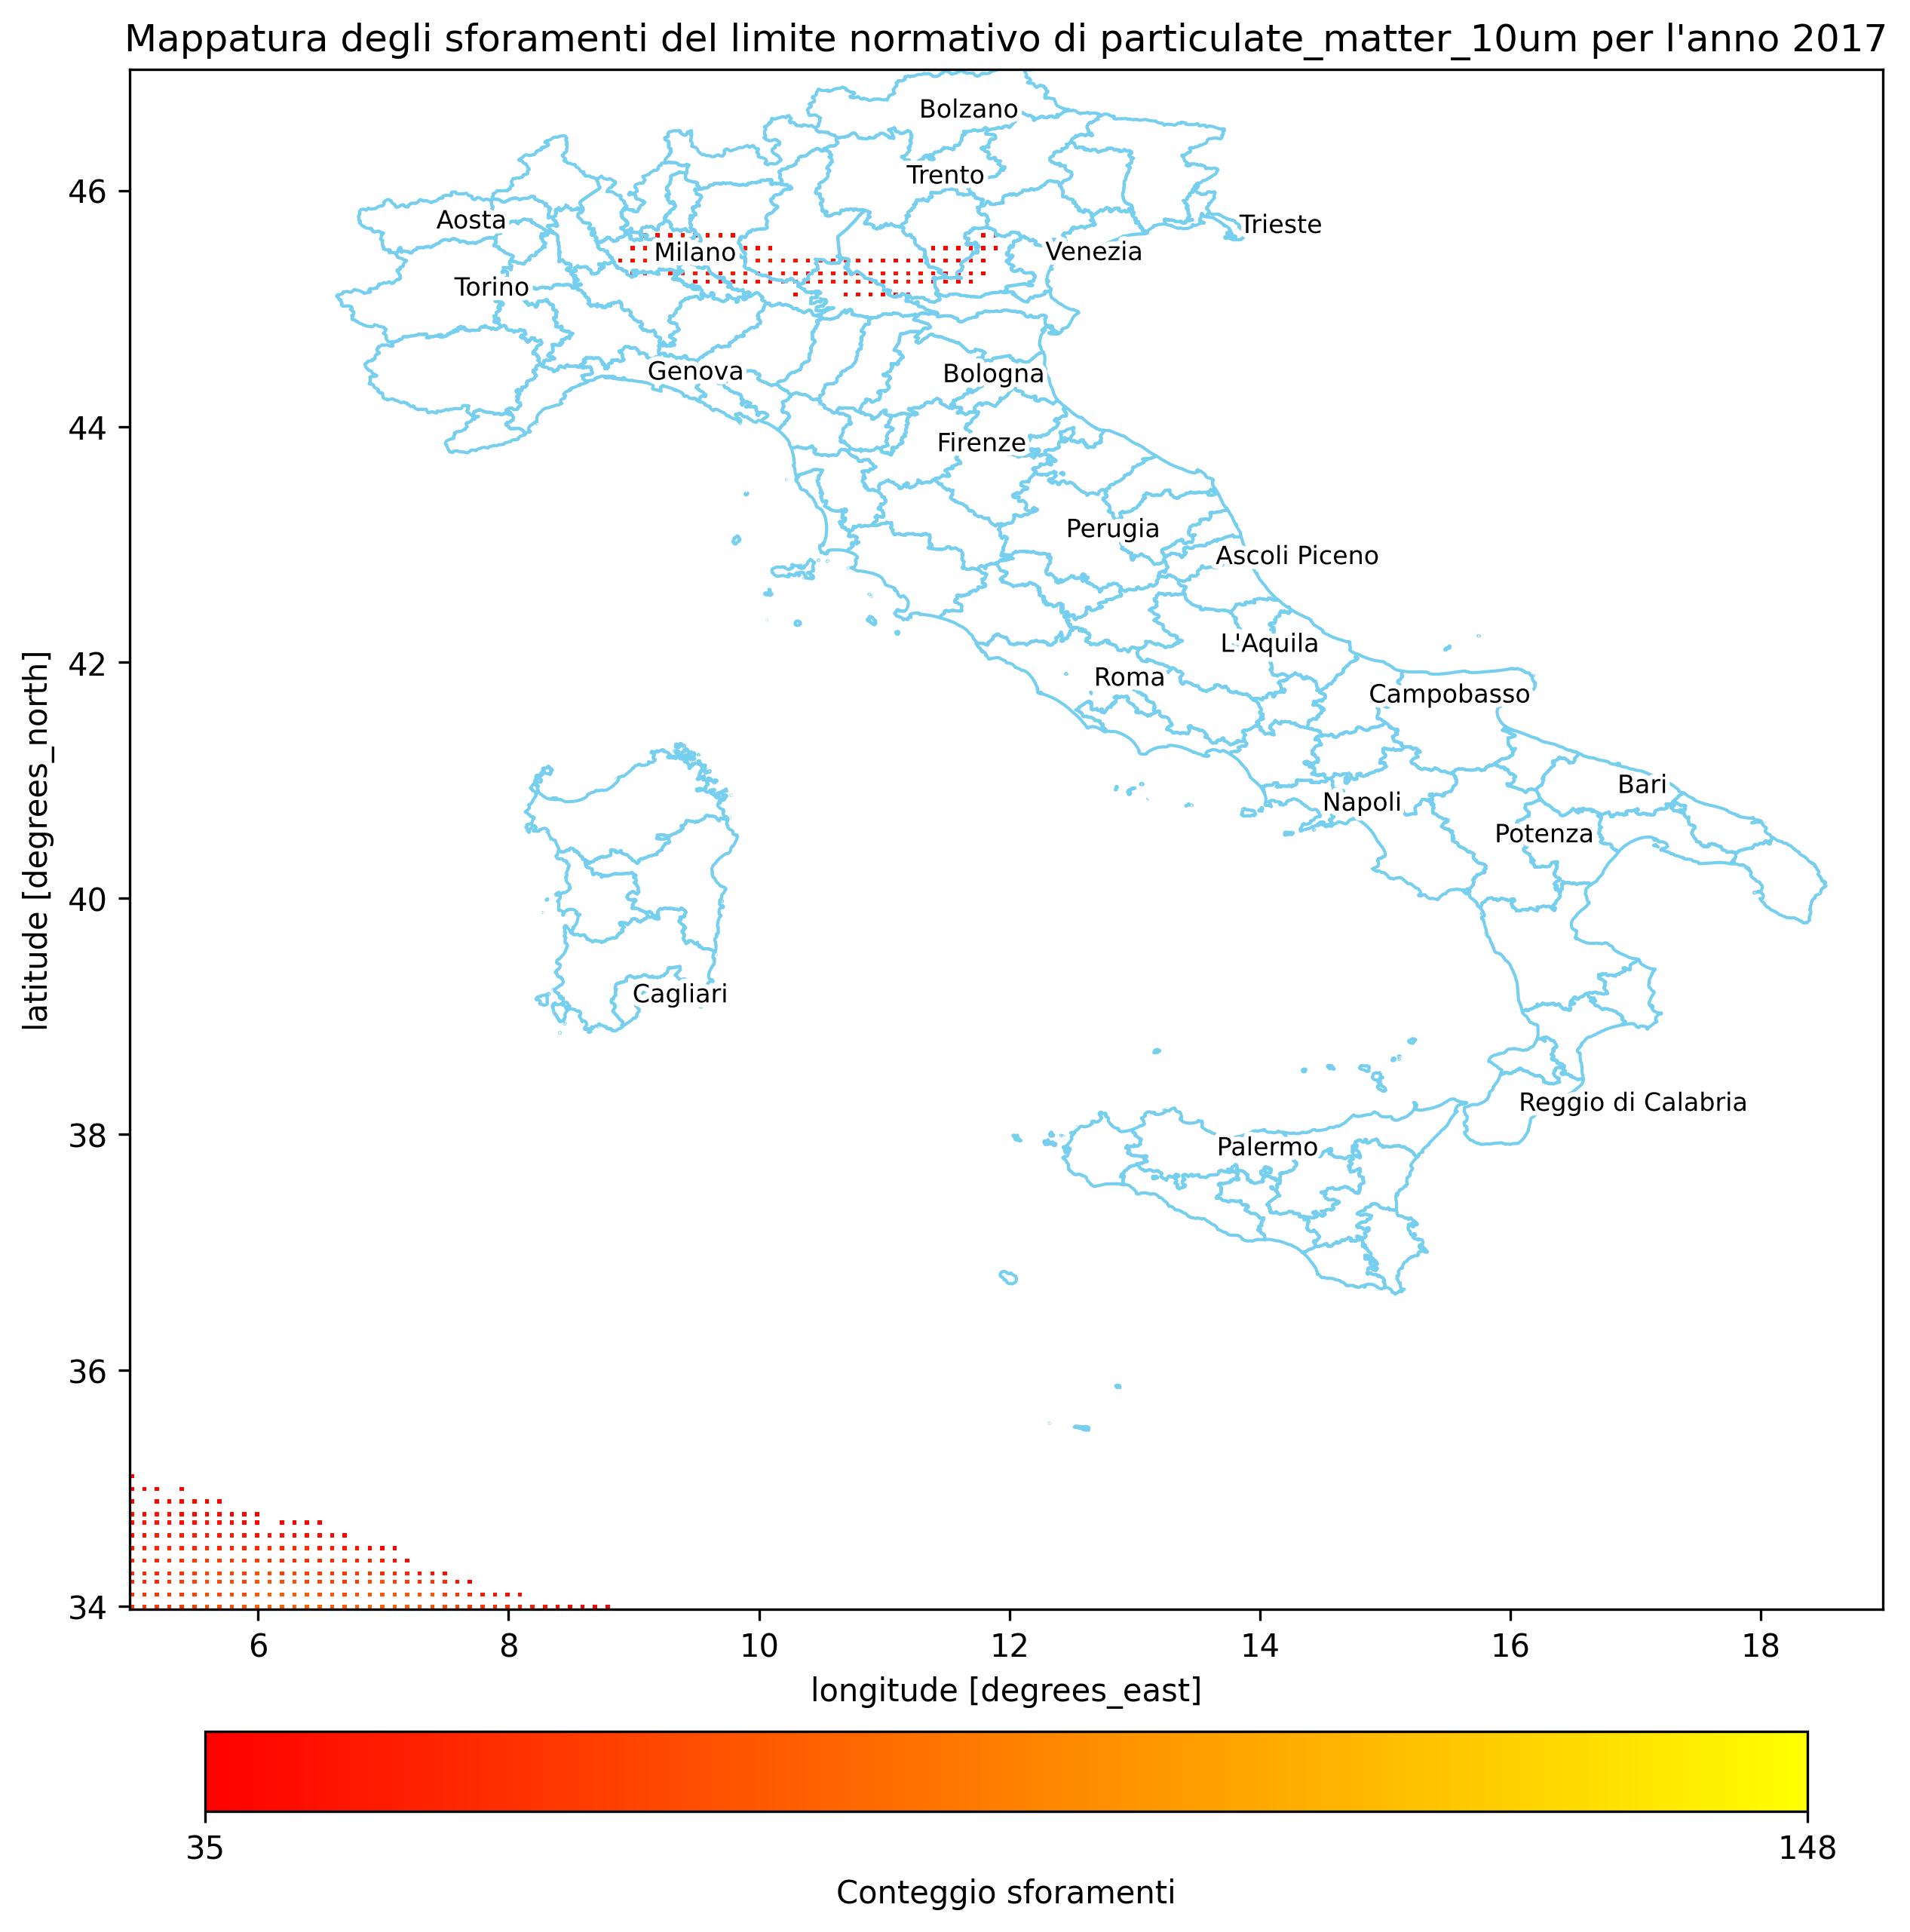

In [32]:
test_year = 2017
test = full_dataset_year_data.sel(time=f"{test_year}-12-31")

fig6, ax6 = plt.subplots(figsize=(figsize_w, figsize_h), dpi=plot_dpi)
target_zones.plot(
    ax=ax6,
    facecolor=polygon_facecolor, 
    edgecolor=polygon_edgecolor,
    linewidth=polygon_linewidth
)
year_data_img_limit = test.to_array().squeeze().plot.imshow(
    ax=ax6,
    cmap=raster_cmap,
    vmin=max_overrunning,
    vmax=full_max,
    add_colorbar=add_colorbar,
)
cbar_ax6 = plt.colorbar(
    year_data_img_limit, 
    ax=ax6,
    orientation=colorbar_orientation,
    fraction=colorbar_fraction, 
    pad=colorbar_pad,
)
cbar_ax6.set_label('Conteggio sforamenti')
cbar_ax6.set_ticks([max_overrunning,  full_max])
cbar_ax6.set_ticks([max_overrunning, full_max])
cbar_ax6.set_ticklabels([str(max_overrunning), str(full_max)])
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    label = plt.text(
        x=coordinates[0][0] + marker_x_offset,
        y=coordinates[1][0] + marker_y_offset,
        s=_row['DEN_UTS'],
        fontdict=dict(color=marker_font_color, size=marker_font_size),
        path_effects=[patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)]
    )
    label.set_path_effects([patheffects.withStroke(linewidth=path_effects_linewidth, foreground=path_effects_foreground)])
plt.title(f"Mappatura degli sforamenti del limite normativo di {pollutant_code} per l'anno {test_year}")

plt.show()

Come si può notare, il raster degli sforamenti risulta quadrettato. Se sai darmi una risposta del perchè accade do 100 punti a Grifondoro.

Se vuoi cimentarti con i dati li trovi [qui](https://1drv.ms/u/s!AvhuPGp5mu9NgoME1PAjaYrFuwPKtg?e=SIA5hh) 